# Occam factor for a Bayesian CNN

- Conceptualizing and illustrating David MacKay's Occam Factor [1] for a Bayesian LeNet CNN with variational inference [2].

[1] *MacKay, David. "Bayesian Methods for Adaptive Models." PhD diss., California Institute of Technology, 1992.*

[2] *Shridhar, Kumar, Felix Laumann, and Marcus Liwicki. "A Comprehensive Guide to Bayesian Convolutional Neural Network with Variational Inference." arXiv preprint arXiv:1901.02731, 2019.*



In [0]:
#!git clone https://github.com/kumar-shridhar/PyTorch-BayesianCNN.git

@article{shridhar2019comprehensive,
  title={A comprehensive guide to bayesian convolutional neural network with variational inference},
  author={Shridhar, Kumar and Laumann, Felix and Liwicki, Marcus},
  journal={arXiv preprint arXiv:1901.02731},
  year={2019}
}

Cloning into 'PyTorch-BayesianCNN'...
remote: Enumerating objects: 296, done.
remote: Counting objects: 100% (296/296), done.
remote: Compressing objects: 100% (173/173), done.
remote: Total 1287 (delta 159), reused 248 (delta 115), pack-reused 991
Receiving objects: 100% (1287/1287), 67.74 MiB | 9.84 MiB/s, done.
Resolving deltas: 100% (760/760), done.


In [0]:
%cd /content/PyTorch-BayesianCNN
!ls


/content/PyTorch-BayesianCNN
config_bayesian.py     layers		    models
config_frequentist.py  LICENSE		    README.md
data		       main_bayesian.py     tests
experiments	       main_frequentist.py  utils.py
__init__.py	       metrics.py	    visualize_mean_var.py


In [0]:
# in order to run this script, you will need to downgrade torchvision and pillow:
import PIL
import torch, torchvision
if torchvision.__version__ == "0.5.0":
  !pip install torchvision==0.4.2
if PIL.__version__ == "7.0.0":
  !pip install pillow==6.2.0

print(torchvision.__version__)
print(PIL.__version__)
# for tracking  cell run times
!pip install ipython-autotime
%load_ext autotime

# Occam factor approximated by sampled weights

As in MacKay's second level of inference, we can compute an approximation of the Occam factor by sampling 2 weights (one random FC weight and one random filter weight), and computing the ratio of the weight's posterior standard deviation to its prior standard deviation.



In [0]:
from __future__ import print_function

import os
import argparse

import torch
import numpy as np
import pandas as pd
from torch.optim import Adam
from torch.nn import functional as F

import data
import utils
import metrics
import config_bayesian as cfg
from models.BayesianModels.Bayesian3Conv3FC import BBB3Conv3FC
from models.BayesianModels.BayesianAlexNet import BBBAlexNet
from models.BayesianModels.BayesianLeNet import BBBLeNet

# CUDA settings
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#how many epochs to train the model for?
N_EPOCHS = 30
#how many times to train each model? Set equal to 1 to retrieve plots of the weight densities
N_MODELS = 15



def getModel(net_type, inputs, outputs):
    if (net_type == 'lenet'):
        return BBBLeNet(outputs,inputs)
    elif (net_type == 'alexnet'):
        return BBBAlexNet(outputs, inputs)
    elif (net_type == '3conv3fc'):
        return BBB3Conv3FC(outputs,inputs)
    else:
        raise ValueError('Network should be either [LeNet / AlexNet / 3Conv3FC')

def calc_uncertainty_softmax(output):
    prediction = F.softmax(output, dim = 1)
    #print(prediction)
    results = torch.max(prediction, 1 )
    #print(results)
    p_hat = np.array(results[0].cpu().detach())
    epistemic = np.mean(p_hat ** 2, axis=0) - np.mean(p_hat, axis=0) ** 2
    epistemic += epistemic 
    #print(epistemic)
    aleatoric = np.mean(p_hat * (1-p_hat), axis = 0)
    aleatoric += aleatoric
    #print (aleatoric)
    return epistemic, aleatoric

def occam(l):
    return l[-1]/l[0]


def train_model(net, optimizer, criterion, trainloader, num_ens=10):
    
    net.train()
    training_loss = 0.0
    accs = []
    kl_list = []
    freq = cfg.recording_freq_per_epoch
    freq = len(trainloader)//freq
    # there are 96 batches
    batch_fcW_list = [] #collect sampled weight into batch list
    batch_convW_list = []
    for i, (inputs, labels) in enumerate(trainloader, 1):
        cfg.curr_batch_no = i
        if i%freq==0:
            cfg.record_now = True
        else:
            cfg.record_now = False

        optimizer.zero_grad()

        inputs, labels = inputs.to(device), labels.to(device)
        outputs = torch.zeros(inputs.shape[0], net.num_classes, num_ens).to(device)

        kl = 0.0
        for j in range(num_ens):
            net_out, _kl = net(inputs)
            kl += _kl
            outputs[:, :, j] = F.log_softmax(net_out, dim=1)
        #for fully connected layer 3:
        which_node = 0
        which_weight = 0
        sampled_fc_weight = net.fc3.W[which_node][which_weight].item()
        #for convolutional layer 1 (choose first of everything):
        which_filter = 0
        which_channel = 0
        which_row = 0
        which_col = 0
        sampled_conv_weight = net.conv1.weight[which_filter][which_channel][which_row][which_col].item()

        batch_fcW_list.append(sampled_fc_weight)
        batch_convW_list.append(sampled_conv_weight)
        kl = kl / num_ens
        kl_list.append(kl.item())
        log_outputs = utils.logmeanexp(outputs, dim=2)

        loss = criterion(log_outputs, labels, kl)
        loss.backward()
        optimizer.step()

        accs.append(metrics.acc(log_outputs.data, labels))
        training_loss += loss.cpu().data.numpy()
    average_sampled_fc_weight_across_batches = np.mean(batch_fcW_list)
    average_sampled_conv_weight_across_batches = np.mean(batch_convW_list)
    print("Across all batches, the average of the sampled FC weight is\t{} and the average of the sampled conv. weight is \t{}".format(average_sampled_fc_weight_across_batches, average_sampled_conv_weight_across_batches))
    return training_loss/len(trainloader), np.mean(accs), np.mean(kl_list), batch_fcW_list, batch_convW_list


def validate_model(net, criterion, validloader, num_ens=1):
    """Calculate ensemble accuracy and NLL Loss"""
    net.eval()
    valid_loss = 0.0
    accs = []

    for i, (inputs, labels) in enumerate(validloader):
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = torch.zeros(inputs.shape[0], net.num_classes, num_ens).to(device)
        kl = 0.0
        for j in range(num_ens):
            net_out, _kl = net(inputs)
            kl += _kl
            outputs[:, :, j] = F.log_softmax(net_out, dim=1).data

        log_outputs = utils.logmeanexp(outputs, dim=2)
        valid_loss += criterion(log_outputs, labels, kl).item()
        accs.append(metrics.acc(log_outputs, labels))

    return valid_loss/len(validloader), np.mean(accs)

def test_model(net, criterion, testloader, num_ens=10):
    """Calculate ensemble accuracy and NLL Loss"""
    net.eval()
    test_loss = 0.0
    accs = []
    epistemic_list = []
    aleatoric_list = []
    for i, (inputs, labels) in enumerate(testloader):
        #print(i)
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = torch.zeros(inputs.shape[0], net.num_classes, num_ens).to(device)
        kl = 0.0
        VI_epistemics = []
        VI_aleatorics = []
        for j in range(num_ens):
            net_out, _kl = net(inputs)
            kl += _kl
            outputs[:, :, j] = F.log_softmax(net_out, dim=1).data
            #print(net_out.shape)
            epistemic , aleatoric = calc_uncertainty_softmax(net_out)
            VI_epistemics.append(epistemic)
            VI_aleatorics.append(aleatoric)
        epistemic_list.append(np.mean(VI_epistemics))
        aleatoric_list.append(np.mean(VI_aleatorics))
        log_outputs = utils.logmeanexp(outputs, dim=2)
        test_loss += criterion(log_outputs, labels, kl).item()
        accs.append(metrics.acc(log_outputs, labels))

        avg_epistemic_uncertainty = np.round(np.mean(epistemic_list), 5) # across ensembles AND batches
        avg_aleatoric_uncertainty =  np.round(np.mean(aleatoric_list), 5)
    return test_loss/len(testloader), np.mean(accs), len(accs),  avg_epistemic_uncertainty, avg_aleatoric_uncertainty###return accs


def run(dataset, net_type):

    # Hyper Parameter settings
    train_ens = cfg.train_ens
    valid_ens = cfg.valid_ens
    lr_start = cfg.lr_start
    num_workers = cfg.num_workers
    valid_size = cfg.valid_size
    batch_size = cfg.batch_size
    n_epochs = N_EPOCHS
    trainset, testset, inputs, outputs = data.getDataset(dataset)
    train_loader, valid_loader, test_loader = data.getDataloader(
        trainset, testset, valid_size, batch_size, num_workers)
    net = getModel(net_type, inputs, outputs).to(device)
    
    ckpt_dir = f'saved_model/{dataset}/bayesian' 
    ckpt_name = f'saved_model/{dataset}/bayesian/model_{net_type}.pt'

    if not os.path.exists(ckpt_dir):
        os.makedirs(ckpt_dir, exist_ok=True)

    criterion = metrics.ELBO(len(trainset)).to(device)
    optimizer = Adam(net.parameters(), lr=lr_start)
    valid_loss_max = np.Inf
    epoch_fc_weight_list = [] 
    epoch_conv_weight_list = []
    for epoch in range(n_epochs):  
        cfg.curr_epoch_no = epoch
        utils.adjust_learning_rate(optimizer, metrics.lr_linear(epoch, 0, n_epochs, lr_start))

        train_loss, train_acc, train_kl, batch_fcW_list, batch_convW_list = train_model(net, optimizer, criterion, train_loader, num_ens=train_ens)

        valid_loss, valid_acc = validate_model(net, criterion, valid_loader, num_ens=valid_ens)

        print('Epoch: {} \tTraining Loss: {:.4f} \tTraining Accuracy: {:.4f} \tValidation Loss: {:.4f} \tValidation Accuracy: {:.4f} \ttrain_kl_div: {:.4f}'.format(
            epoch, train_loss, train_acc, valid_loss, valid_acc, train_kl))
        # take std dev for the sampled fc and conv weights across the batches, to see if std dev decreases with more training
        epoch_fc_weight_list.append(np.std(batch_fcW_list)) 
        epoch_conv_weight_list.append(np.std(batch_convW_list))
       
        # save model if validation accuracy has increased
        if valid_loss <= valid_loss_max:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
                valid_loss_max, valid_loss))
            torch.save(net.state_dict(), ckpt_name)
            valid_loss_max = valid_loss

    return net, criterion, test_loader, ckpt_name, train_acc, epoch_fc_weight_list, epoch_conv_weight_list

if __name__ == '__main__':
    NET_TYPE = 'lenet'
    DATASET = 'MNIST'

    parser = argparse.ArgumentParser(description = "PyTorch Bayesian Model Training")
    parser.add_argument('--net_type', default=NET_TYPE, type=str, help='model')
    parser.add_argument('--dataset', default=DATASET, type=str, help='dataset = [MNIST/CIFAR10/CIFAR100]')
    parser.add_argument('-f')
    args = parser.parse_args()

    if cfg.record_mean_var:
        mean_var_dir = f"graphs_progress/{args.dataset}/bayesian/{args.net_type}/"
        cfg.mean_var_dir = mean_var_dir
        if not os.path.exists(mean_var_dir):
            os.makedirs(mean_var_dir, exist_ok=True)

        for file in os.listdir(mean_var_dir):
            os.remove(mean_var_dir + file)

    # metrics to track
    test_accuracies = []
    generalization_gaps = []
    fc_occams = []
    conv_occams = []
    epistemics = []
    aleatorics = []
    test_losses = []

    for j in range(N_MODELS):
        net, criterion, test_loader, ckpt_name, train_acc, epoch_fc_weight_list, epoch_conv_weight_list = run(args.dataset, args.net_type)
        occam_fc = occam(epoch_fc_weight_list)
        occam_conv = occam(epoch_conv_weight_list)
        test_loss, test_acc, _, avg_epistemic, avg_aleatoric = test_model(net, criterion, test_loader)
        gg = train_acc - test_acc
        
        test_accuracies.append(test_acc)
        generalization_gaps.append(gg)
        fc_occams.append(occam_fc)
        conv_occams.append(occam_conv)
        epistemics.append(avg_epistemic)
        aleatorics.append(avg_aleatoric)
        test_losses.append(test_loss)
    model_number = list(range(1, N_MODELS+1))
    # Create a zipped list of tuples from above lists
    zippedList =  list(zip(model_number, test_accuracies, generalization_gaps, epistemics, aleatorics, fc_occams, conv_occams, test_losses))
    # Create a dataframe from zipped list
    dfObj = pd.DataFrame(zippedList, columns = ['Model Number','Test Accuracy' , 'Generalization Gap', 'Avg. Epistemic', 'Avg. Aleatoric', 'Occam factor (FC)', 'Occam factor (Filter)', 'Test Loss']) 
    directory_to_save_csv = 'result/'
    if not os.path.exists(directory_to_save_csv):
        os.makedirs(directory_to_save_csv)
    file_name = f"result_dataframe_for_{N_EPOCHS}_epochs.csv"
    dfObj.to_csv(directory_to_save_csv + file_name, index = False, header=True)


/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


Across all batches, the average of the sampled FC weight is	-0.053323336062021554 and the average of the sampled conv. weight is 	-0.06760577183592886
Epoch: 0 	Training Loss: 284545.7026 	Training Accuracy: 0.1827 	Validation Loss: 229890.3913 	Validation Accuracy: 0.5453 	train_kl_div: 152431.4844
Validation loss decreased (inf --> 229890.391276).  Saving model ...
Across all batches, the average of the sampled FC weight is	-0.07637279434129596 and the average of the sampled conv. weight is 	0.048975919067743234
Epoch: 1 	Training Loss: 196356.9867 	Training Accuracy: 0.7409 	Validation Loss: 182015.4818 	Validation Accuracy: 0.8126 	train_kl_div: 149593.9712
Validation loss decreased (229890.391276 --> 182015.481771).  Saving model ...
Across all batches, the average of the sampled FC weight is	-0.08863261458463967 and the average of the sampled conv. weight is 	0.09347148138719301
Epoch: 2 	Training Loss: 174647.6165 	Training Accuracy: 0.8469 	Validation Loss: 169961.3691 	Validat

# Visualizing the Occam factor 

- By graphing the reduction in standard deviation of the filter and fully-connected weights separately, we can get an insight into their nature during the updating of the variational posterior.

- The Occam factor can be approximated by 

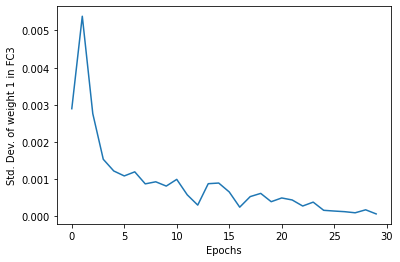

Occam factor is: 	0.022478382232582528


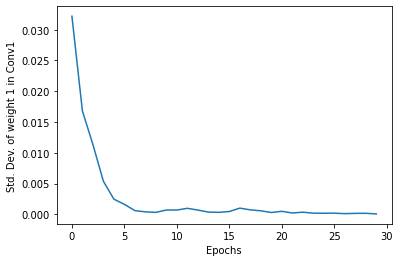

Occam factor is: 	0.0019795769180163906
time: 386 ms


In [0]:
#fully connected weight
import matplotlib.pyplot as plt
plt.plot(epoch_fc_weight_list)
plt.ylabel('Std. Dev. of weight 1 in FC3')
plt.xlabel('Epochs')
plt.show()
of_fc = epoch_fc_weight_list[-1]/epoch_fc_weight_list[0]
print("Occam factor is: \t{}".format(of_fc)) 

#convolutional weight
import matplotlib.pyplot as plt
plt.plot(epoch_conv_weight_list)
plt.ylabel('Std. Dev. of weight 1 in Conv1')
plt.xlabel('Epochs')
plt.show()
of_conv = epoch_conv_weight_list[-1]/epoch_conv_weight_list[0]
print("Occam factor is: \t{}".format(of_conv)) 